In [15]:
import re
import pandas as pd
from new_env import *
import json
import pickle

In [16]:
from torch_geometric.loader import DataLoader

In [20]:
with open("include_probability.json") as f:
    db = json.load(f)

reverse_database = {(value[0], value[1]) : key for key, value in db.items()}


In [0]:
all_premises = []
premise_labels = []
premise_idx = []
for i, (key, value) in enumerate(db.items()):
    if value[0] == "pred_set" or value[0] == "relation" or value[0] == "list":# or value[0] == "rich_list" or value[0] == "prim_rec": #or value[0] == "pred_set" or value[0] == "set":
        all_premises.append(key)
        premise_labels.append(value[0])
        premise_idx.append(i)

In [34]:
from sklearn.decomposition import PCA
import plotly.express as px
#3d
def plot_reps(reps, labels, n_components, graph_name):

    # pca = PCA(n_components)
    # tsne_result = pca.fit_transform(reps.detach().cpu().numpy())

    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(reps.detach().cpu().numpy())

    color_dict = {}

    i = 0
    for label in set(labels):
        print (label, i)
        color_dict[label] = i
        i += 1

    color_dict["POI1"] = i + 1
    color_dict["POI2"] = i + 1
    color_dict["POI3"] = i + 1
    color_dict["POI4"] = i + 1

    if n_components == 3:

        df_list = []
        for i, premise in enumerate(all_premises):
            # set custom markers for points of interest
            if i == 1255 or i == 1256 or i == 1290 or i == 1291:
                labels[i] = "POI1"
            if i == 403 or i == 418:
                labels[i] = "POI2"
            if i == 497 or i == 387:
                labels[i] = "POI3"
            if i == 1097 or i == 810 or i == 591:
                labels[i] = "POI4"
            df_list.append({'Premise': db[premise][-1], 'X': tsne_result[i,0], "Y": tsne_result[i,1], "Z": tsne_result[i,2], "Thm": premise_labels[i], "Idx": i})

        df = pd.DataFrame.from_records(df_list)


        fig = px.scatter_3d(df, x = 'X', y = 'Y', z = 'Z', color = 'Thm', hover_name = "Premise", hover_data = ["Thm", "Idx"])
        fig.update_traces(marker_size = 3)

        fig.write_html(graph_name+".html", auto_open=True)
        # ax = plt.figure(figsize=(16,10)).gca(projection='3d')
        # scatter = ax.scatter(xs=tsne_result[:,0], ys=tsne_result[:,1], zs=tsne_result[:,2], c = [color_dict[l] for l in labels])#, cmap="tab10")

    else:
        ax = plt.figure(figsize=(16,10)).gca()
        scatter = ax.scatter(x = tsne_result[:,0], y = tsne_result[:,1], c = [color_dict[l] for l in labels])#, label = labels_th)

        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
        ax.add_artist(legend1)

        plt.show()

    return tsne_result, premise_labels



In [38]:
import matplotlib.pyplot as plt

pred_set 0
POI4 1
POI3 2
POI1 3
list 4
POI2 5
relation 6


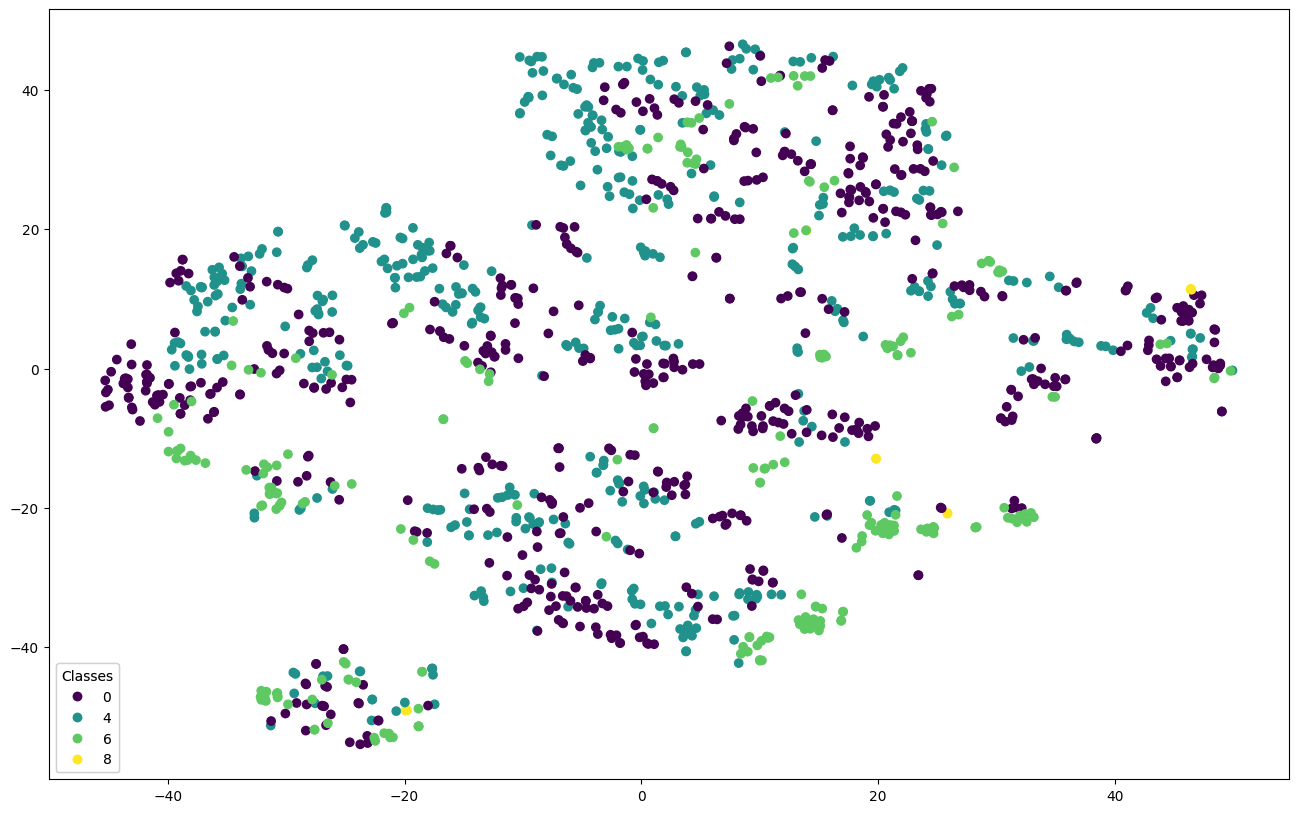

In [39]:
vanilla_tsne, v_labs = plot_reps(vanilla_premise_reps, premise_labels, 2, "vanilla_premise_rep_graph_new_2")

pred_set 0
POI4 1
POI3 2
POI1 3
list 4
POI2 5
relation 6


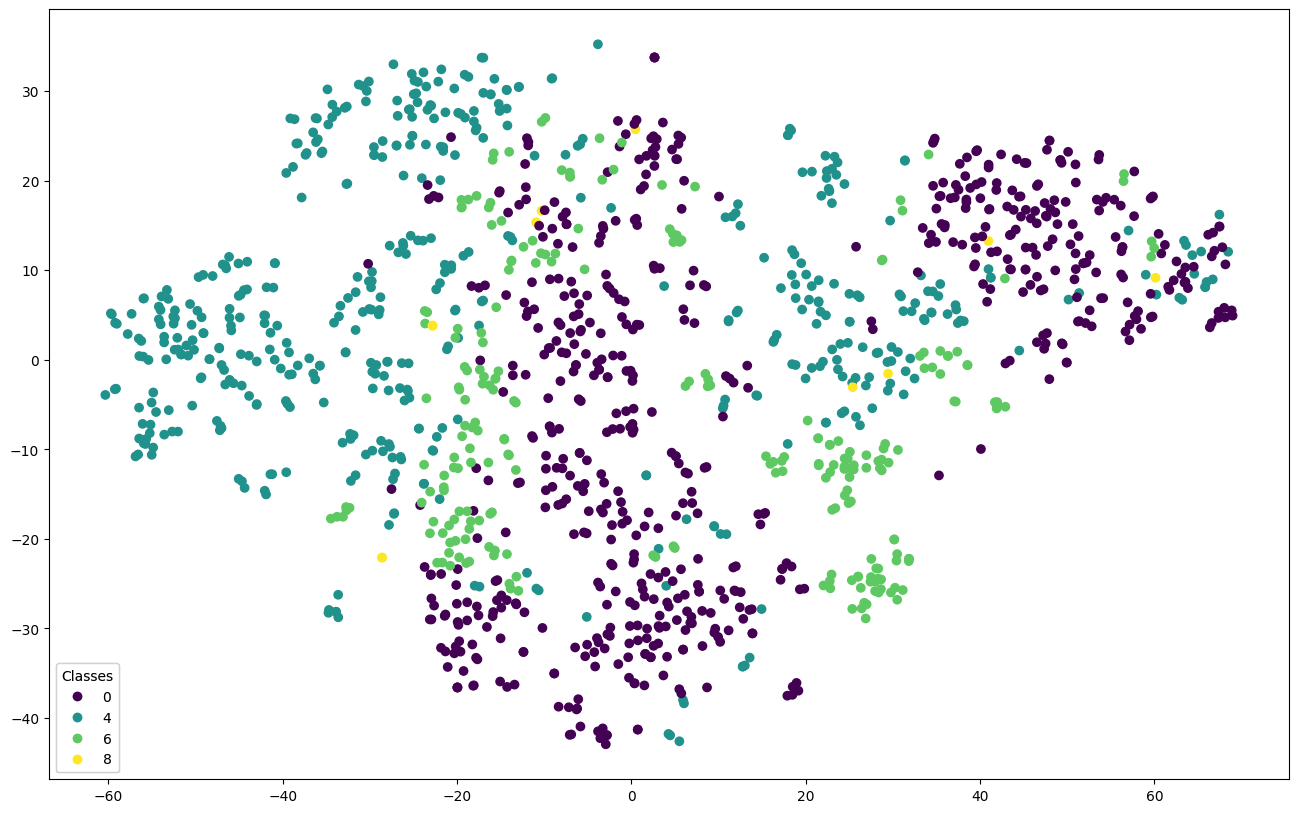

In [40]:
gnn_tsne, g_labs = plot_reps(premise_representations, premise_labels, 2, "gnn_premise_rep_graph_new_2")

In [42]:
vanilla_premise_reps.shape

torch.Size([1372, 256])

In [79]:
db[all_premises[0]][-1]

'FINITE 𝕌(:α # β) ⇔ FINITE 𝕌(:α) ∧ FINITE 𝕌(:β)'

In [249]:
with open("vanilla_reps.pk", "wb") as f:
    pickle.dump(vanilla_premise_reps,f)

In [82]:
cos = lambda m: F.normalize(m) @ F.normalize(m).t()
torch.topk(cos(vanilla_premise_reps)[0], 5)[1]

tensor([   0, 1024,  686,  918,  958])

In [86]:
vclosest = {}
gclosest = {}
def get_closest(ind):
    inds = torch.topk(cos(vanilla_premise_reps)[ind], 5)[1][1:]
    vclosest[db[all_premises[ind]][-1]] = [db[all_premises[x]][-1] for x in inds]
    inds = torch.topk(cos(premise_representations)[ind], 5)[1][1:]
    gclosest[db[all_premises[ind]][-1]] = [db[all_premises[x]][-1] for x in inds]
    
    
    
    

In [87]:
for i in range(len(all_premises)):
    get_closest(i)
    

In [91]:
gclosest

{'FINITE 𝕌(:α # β) ⇔ FINITE 𝕌(:α) ∧ FINITE 𝕌(:β)': ['INFINITE 𝕌(:α) ⇔ ∀(s :α -> bool). FINITE s ⇒ s ⊂ 𝕌(:α)',
  'INFINITE 𝕌(:α) ⇔ ∃(f :α -> α). (∀(x :α) (y :α). f x = f y ⇒ x = y) ∧ ∃(y :α). ∀(x :α). f x ≠ y',
  '∀(P :α -> bool) (Q :β -> bool). FINITE P ∧ FINITE Q ⇒ FINITE ((P × Q) :α # β -> bool)',
  'FINITE (POW (s :α -> bool)) ⇔ FINITE s'],
 'LIST_REL (R :α -> β -> bool) (l1 :α list) (l2 :β list) ∧ LIST_REL R (l3 :α list) (l4 :β list) ⇒ LIST_REL R (l1 ++ l3) (l2 ++ l4)': ['LENGTH (x1 :α list) = LENGTH (x2 :β list) ⇒ (LIST_REL (R :α -> β -> bool) (x1 ++ (y1 :α list)) (x2 ++ (y2 :β list)) ⇔ LIST_REL R x1 x2 ∧ LIST_REL R y1 y2)',
  'LIST_REL (R :α -> β -> bool) (l1 :α list) (l2 :β list) ∧ LIST_REL R (l3 :α list) (l4 :β list) ⇔ LIST_REL R (l1 ++ l3) (l2 ++ l4) ∧ LENGTH l1 = LENGTH l2 ∧ LENGTH l3 = LENGTH l4',
  '∀(xs :α list) (ys :β list) (xs1 :α list) (ys1 :β list). LIST_REL (P :α -> β -> bool) (xs ++ xs1) (ys ++ ys1) ∧ LENGTH xs = LENGTH ys ⇒ LIST_REL P xs ys ∧ LIST_REL P xs1 ys1',
  

In [92]:
vclosest

{'FINITE 𝕌(:α # β) ⇔ FINITE 𝕌(:α) ∧ FINITE 𝕌(:β)': ['COUNTABLE 𝕌(:α # β) ⇔ COUNTABLE 𝕌(:α) ∧ COUNTABLE 𝕌(:β)',
  '(s1 :α -> bool) ⊆ (s2 :α -> bool) ⇒ REL_RESTRICT (R :α -> α -> bool) s1 ⊆ᵣ REL_RESTRICT R s2',
  'INFINITE 𝕌(:α) ⇔ ∀(s :α -> bool). FINITE s ⇒ s ⊂ 𝕌(:α)',
  '(R :α -> α -> bool) equiv_on (s :α -> bool) ⇒ (∅ :α -> bool) ∉ partition R s'],
 'LIST_REL (R :α -> β -> bool) (l1 :α list) (l2 :β list) ∧ LIST_REL R (l3 :α list) (l4 :β list) ⇒ LIST_REL R (l1 ++ l3) (l2 ++ l4)': ['(∀(m :num). m < (n :num) ⇒ (f1 :num -> α) m = (f2 :num -> α) m) ⇒ GENLIST f1 n = GENLIST f2 n',
  '(∀(x :α). (P :α -> bool) x ⇒ (Q :α -> bool) x) ⇒ EXISTS P (l :α list) ⇒ EXISTS Q l',
  '(∀(x :α). (P :α -> bool) x ⇒ (Q :α -> bool) x) ⇒ EVERY P (l :α list) ⇒ EVERY Q l',
  '(R1 :α -> β -> bool) ⊆ᵣ (R2 :α -> β -> bool) ∧ (S1 :γ -> α -> bool) ⊆ᵣ (S2 :γ -> α -> bool) ⇒ R1 ∘ᵣ S1 ⊆ᵣ R2 ∘ᵣ S2'],
 'LIST_REL (R :α -> β -> bool) (l1 :α list) (l2 :β list) ∧ LIST_REL R (l3 :α list) (l4 :β list) ⇔ LIST_REL R (l1 ++ l3) (l

In [241]:
ret = []
# pois = [17, 18, 1334, 1323, 1322, 1315, 1303, 622, 621, 620, 604, 584, 583, 582, 581, 1255, 1290]
# pois = [61]
inds = [i for i,x in enumerate(all_premises)]
random.shuffle(inds)
j = 0
for i in inds:
    if j == 20:
        break
    prem = db[all_premises[i]][-1]
    # print (i)
    # print ()
    # print(f"{prem}\n gnn: {gclosest[prem][0]}\n AE: {vclosest[prem][0]}\n")
    if len(gclosest[prem][0]) < 60 and len(vclosest[prem][0]) < 60 and len(prem) < 60:
        ret.append((prem, gclosest[prem][0], vclosest[prem][0]))
        print (i)
        print ()
        print(f"{prem}\n gnn: {gclosest[prem][0]}\n AE: {vclosest[prem][0]}\n")
        j += 1


120

LIST_BIND (l :α list) (λ(x :α). [x]) = l
 gnn: LIST_BIND [(x :β)] (f :β -> α list) = f x
 AE: ∀(n :num) (l :α list). TAKE n l ++ DROP n l = l

523

∀(s :α -> bool). REST s = s DELETE CHOICE s
 gnn: ∀(s :α -> bool). CHOICE s ∉ REST s
 AE: ∀(s :α -> bool). FINITE s ⇔ s HAS_SIZE CARD s

937

∀(n :num). FINITE (count n)
 gnn: ∀(ls :α list). ALL_DISTINCT ls ⇒ CARD (set ls) = LENGTH ls
 AE: ∀(n :num). COUNTABLE (count n)

1106

∀(x :α -> bool). BIGUNION {x} = x
 gnn: ∀(s :α -> bool) (t :α -> bool). BIGUNION {s; t} = s ∪ t
 AE: ∀(x :α). CHOICE {x} = x

970

∀(x :α). DISJOINT {x} (∅ :α -> bool)
 gnn: ∀(s :α -> bool) (x :α). s DELETE x = s DIFF {x}
 AE: ∀(s :α -> bool). s DIFF 𝕌(:α) = (∅ :α -> bool)

1300

(reflexive (R :α -> α -> bool)^= :bool)
 gnn: ∀(R :α -> α -> bool). equivalence R^=
 AE: symmetric (R :α -> α -> bool)^=

742

∀(x :α) (s :α -> bool). x INSERT s ≠ (∅ :α -> bool)
 gnn: ∀(x :α) (s :α -> bool). (∅ :α -> bool) ≠ x INSERT s
 AE: ∀(s :α -> bool). s DIFF s = (∅ :α -> bool)

91

In [239]:
len(ret)

20

In [214]:
all_premises[61]

'@ C$bool$ ! | Vl @ @ C$min$ = @ C$list$ ZIP @ C$list$ UNZIP Vl Vl'

In [217]:
db['∀(l1 :α list) (l2 :β list). LENGTH l1 = LENGTH l2 ⇒ UNZIP (ZIP (l1,l2)) = (l1,l2)']

KeyError: '∀(l1 :α list) (l2 :β list). LENGTH l1 = LENGTH l2 ⇒ UNZIP (ZIP (l1,l2)) = (l1,l2)'

In [215]:
gclosest['∀(l :(α # β) list). ZIP (UNZIP l) = l']

['∀(l1 :α list) (l2 :β list). LENGTH l1 = LENGTH l2 ⇒ UNZIP (ZIP (l1,l2)) = (l1,l2)',
 '∀(l1 :α list) (l2 :β list). LENGTH l1 = LENGTH l2 ⇒ LENGTH (ZIP (l1,l2)) = LENGTH l1 ∧ LENGTH (ZIP (l1,l2)) = LENGTH l2',
 '∀(R :α -> α -> bool) (f :β -> α). (reflexive R :bool) ⇒ (reflexive (inv_image R f) :bool)',
 '∀(P :α -> β -> bool) (l1 :α list) (l2 :β list). LIST_REL P l1 l2 ⇒ LENGTH l1 = LENGTH l2']

In [197]:
from pylatexenc.latexencode import UnicodeToLatexEncoder

In [198]:
u = UnicodeToLatexEncoder(unknown_char_policy='replace')
print(u.unicode_to_latex('(R1 :α -> β -> bool) ∩ᵣ (R2 :α -> β -> bool) = R2 ∩ᵣ R1')))

No known latex representation for character: U+1D63 - ‘ᵣ’
No known latex representation for character: U+1D63 - ‘ᵣ’


(R1 :\ensuremath{\alpha} -\ensuremath{>} \ensuremath{\beta} -\ensuremath{>} bool) \ensuremath{\cap}{\bfseries ?} (R2 :\ensuremath{\alpha} -\ensuremath{>} \ensuremath{\beta} -\ensuremath{>} bool) = R2 \ensuremath{\cap}{\bfseries ?} R1


In [242]:
new_ret = []

for r in ret:
    new_ret.append([u.unicode_to_latex(x) for x in r])

No known latex representation for character: U+1D63 - ‘ᵣ’


In [243]:
with open("latex_out_2", "wb") as f:
    pickle.dump(new_ret, f)

In [246]:
new_ret[0]

['LIST\\_BIND (l :\\ensuremath{\\alpha} list) (\\ensuremath{\\lambda}(x :\\ensuremath{\\alpha}). [x]) = l',
 'LIST\\_BIND [(x :\\ensuremath{\\beta})] (f :\\ensuremath{\\beta} -\\ensuremath{>} \\ensuremath{\\alpha} list) = f x',
 '\\ensuremath{\\forall}(n :num) (l :\\ensuremath{\\alpha} list). TAKE n l ++ DROP n l = l']

In [212]:
sx = [u.unicode_to_latex(r) for r in ret]



In [213]:
for s in sx:
    print (s)

('\ensuremath{\forall}(l :(\ensuremath{\alpha} \# \ensuremath{\beta}) list). ZIP (UNZIP l) = l', '\ensuremath{\forall}(l1 :\ensuremath{\alpha} list) (l2 :\ensuremath{\beta} list). LENGTH l1 = LENGTH l2 \ensuremath{\Rightarrow} UNZIP (ZIP (l1,l2)) = (l1,l2)', '\ensuremath{\forall}(l :\ensuremath{\alpha} list). REVERSE (REVERSE l) = l')


In [150]:
with open("pois.pk", "wb") as f:
    pickle.dump(ret, f)

In [204]:
new_ret[0]

['\\ensuremath{\\forall}(c :\\ensuremath{\\alpha}) (n :num) (s :\\ensuremath{\\alpha} list). PAD\\_RIGHT c n s = s ++ GENLIST (K c :num -\\ensuremath{>} \\ensuremath{\\alpha}) (n \\ensuremath{-} LENGTH s)',
 '\\ensuremath{\\forall}(c :\\ensuremath{\\alpha}) (n :num) (s :\\ensuremath{\\alpha} list). PAD\\_LEFT c n s = GENLIST (K c :num -\\ensuremath{>} \\ensuremath{\\alpha}) (n \\ensuremath{-} LENGTH s) ++ s',
 '\\ensuremath{\\forall}(s :num -\\ensuremath{>} bool). FINITE s \\ensuremath{\\Rightarrow} \\ensuremath{\\forall}(x :num). x \\ensuremath{\\in} s \\ensuremath{\\Rightarrow} x \\ensuremath{\\leq} MAX\\_SET s']

In [141]:

prem = db[all_premises[591]][-1]
print ()
print (f"{prem}\n gnn: {gclosest[prem][0]}\n AE: {vclosest[prem][0]}\n")



∀(s :α -> bool). SURJ (λ(x :α). x) s s
 gnn: ∀(f :α -> β) (g :β -> γ) (s :α -> bool) (t :β -> bool) (u :γ -> bool). SURJ f s t ∧ SURJ g t u ⇒ SURJ (g ∘ f) s u
 AE: ∀(s :α -> bool). INJ (λ(x :α). x) s s
